In [2]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [3]:
df = pd.read_parquet("hf://datasets/qiaojin/PubMedQA/pqa_artificial/train-00000-of-00001.parquet")

In [5]:
df.head()

,pubid,question,context,long_answer,final_decision
0,25429730,Are group 2 innate lymphoid cells ( ILC2s ) in...,{'contexts': ['Chronic rhinosinusitis (CRS) is...,"As ILC2s are elevated in patients with CRSwNP,...",yes
1,25433161,Does vagus nerve contribute to the development...,{'contexts': ['Phosphatidylethanolamine N-meth...,Neuronal signals via the hepatic vagus nerve c...,yes
2,25445714,Does psammaplin A induce Sirtuin 1-dependent a...,{'contexts': ['Psammaplin A (PsA) is a natural...,PsA significantly inhibited MCF-7/adr cells pr...,yes
3,25431941,Is methylation of the FGFR2 gene associated wi...,{'contexts': ['This study examined links betwe...,We identified a novel biologically plausible c...,yes
4,25432519,Do tumor-infiltrating immune cell profiles and...,{'contexts': ['Tumor microenvironment immunity...,Breast cancer immune cell subpopulation profil...,yes


## Dropping unnecessary columns

In [6]:
df["context"][0]

{'contexts': array(['Chronic rhinosinusitis (CRS) is a heterogeneous disease with an uncertain pathogenesis. Group 2 innate lymphoid cells (ILC2s) represent a recently discovered cell population which has been implicated in driving Th2 inflammation in CRS; however, their relationship with clinical disease characteristics has yet to be investigated.',
        'The aim of this study was to identify ILC2s in sinus mucosa in patients with CRS and controls and compare ILC2s across characteristics of disease.',
        'A cross-sectional study of patients with CRS undergoing endoscopic sinus surgery was conducted. Sinus mucosal biopsies were obtained during surgery and control tissue from patients undergoing pituitary tumour resection through transphenoidal approach. ILC2s were identified as CD45(+) Lin(-) CD127(+) CD4(-) CD8(-) CRTH2(CD294)(+) CD161(+) cells in single cell suspensions through flow cytometry. ILC2 frequencies, measured as a percentage of CD45(+) cells, were compared across C

In [7]:
# Convert the dictionary in 'context' column to a string
df['context_str'] = df['context'].apply(lambda x: ' '.join([str(key) + ': ' + ' '.join(value) for key, value in x.items()]))

Extract the relevant parts of the dictionary (like the text in contexts) and ignore the other parts 

In [8]:
df['context_str'][0]

'contexts: Chronic rhinosinusitis (CRS) is a heterogeneous disease with an uncertain pathogenesis. Group 2 innate lymphoid cells (ILC2s) represent a recently discovered cell population which has been implicated in driving Th2 inflammation in CRS; however, their relationship with clinical disease characteristics has yet to be investigated. The aim of this study was to identify ILC2s in sinus mucosa in patients with CRS and controls and compare ILC2s across characteristics of disease. A cross-sectional study of patients with CRS undergoing endoscopic sinus surgery was conducted. Sinus mucosal biopsies were obtained during surgery and control tissue from patients undergoing pituitary tumour resection through transphenoidal approach. ILC2s were identified as CD45(+) Lin(-) CD127(+) CD4(-) CD8(-) CRTH2(CD294)(+) CD161(+) cells in single cell suspensions through flow cytometry. ILC2 frequencies, measured as a percentage of CD45(+) cells, were compared across CRS phenotype, endotype, inflamma

In [9]:
df.drop(columns=['pubid','context'], inplace= True)

In [10]:
df.head()

,question,long_answer,final_decision,context_str
0,Are group 2 innate lymphoid cells ( ILC2s ) in...,"As ILC2s are elevated in patients with CRSwNP,...",yes,contexts: Chronic rhinosinusitis (CRS) is a he...
1,Does vagus nerve contribute to the development...,Neuronal signals via the hepatic vagus nerve c...,yes,contexts: Phosphatidylethanolamine N-methyltra...
2,Does psammaplin A induce Sirtuin 1-dependent a...,PsA significantly inhibited MCF-7/adr cells pr...,yes,contexts: Psammaplin A (PsA) is a natural prod...
3,Is methylation of the FGFR2 gene associated wi...,We identified a novel biologically plausible c...,yes,contexts: This study examined links between DN...
4,Do tumor-infiltrating immune cell profiles and...,Breast cancer immune cell subpopulation profil...,yes,contexts: Tumor microenvironment immunity is a...


In [11]:
# check the shape of the dataset
df.shape

(211269, 4)

# Feature Engineering

In [12]:
# checks for null values in the dataset
df.isnull().sum()

question          0
long_answer       0
final_decision    0
context_str       0
dtype: int64

In [13]:
# Counting the total number of final_decision present in the dataset
final_decision_count = df["final_decision"].value_counts()
final_decision_count

final_decision
yes    196144
no      15125
Name: count, dtype: int64

## Creating a balanced dataset of 500 datapoints in total

Since the results show that our dataset is imbalanced, 
we need to create a balanced dataset, to get quality results at the end.


Start by separating the data first each class and saving them in a variable

In [14]:
majority_class = df[df.final_decision == 'yes'] 
minority_class = df[df.final_decision == 'no']

Next, take 250 data point from each class, where we will have 500 in total.
In this case, we guarantee that our dataset is balanced.

In [15]:
df_yes = majority_class[:250]
df_no = minority_class[:250]

now concatenate the df_yes class and the df_no class with the balanced data points.

In [16]:
balanced_data = pd.concat([df_yes, df_no],axis=0)

In [17]:
balanced_data.head()

,question,long_answer,final_decision,context_str
0,Are group 2 innate lymphoid cells ( ILC2s ) in...,"As ILC2s are elevated in patients with CRSwNP,...",yes,contexts: Chronic rhinosinusitis (CRS) is a he...
1,Does vagus nerve contribute to the development...,Neuronal signals via the hepatic vagus nerve c...,yes,contexts: Phosphatidylethanolamine N-methyltra...
2,Does psammaplin A induce Sirtuin 1-dependent a...,PsA significantly inhibited MCF-7/adr cells pr...,yes,contexts: Psammaplin A (PsA) is a natural prod...
3,Is methylation of the FGFR2 gene associated wi...,We identified a novel biologically plausible c...,yes,contexts: This study examined links between DN...
4,Do tumor-infiltrating immune cell profiles and...,Breast cancer immune cell subpopulation profil...,yes,contexts: Tumor microenvironment immunity is a...


## Preprocessing the new balanced dataset

In [18]:
#nltk download stop words
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Firas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
#download nltk punkt datas
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Firas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
#initialize the stemmer
ps = PorterStemmer()

# preprocessing function
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Filter out non-alphanumeric tokens
    tokens = [token for token in tokens if token.isalnum()]
    
    # Remove stopwords and punctuation
    tokens = [token for token in tokens if token not in stopwords.words("english") and token not in string.punctuation]
    
    # Stem the tokens
    tokens = [ps.stem(token) for token in tokens]
    
    # Join the tokens back into a single string
    return " ".join(tokens)


## Creating a new column in the dataset and inserting all the pre-proccessed texts inside it

In [21]:
#add the code to apply the preprocess_text function on all the news text column
balanced_data['preprocessed_question'] = balanced_data['question'].apply(preprocess_text)
balanced_data['preprocessed_context'] = balanced_data['context_str'].apply(preprocess_text)
balanced_data['preprocessed_long_answer'] = balanced_data['long_answer'].apply(preprocess_text)

In [22]:
balanced_data.head()

,question,long_answer,final_decision,context_str,preprocessed_question,preprocessed_context,preprocessed_long_answer
0,Are group 2 innate lymphoid cells ( ILC2s ) in...,"As ILC2s are elevated in patients with CRSwNP,...",yes,contexts: Chronic rhinosinusitis (CRS) is a he...,group 2 innat lymphoid cell ilc2 increas chron...,context chronic rhinosinus cr heterogen diseas...,ilc2 elev patient crswnp may drive nasal polyp...
1,Does vagus nerve contribute to the development...,Neuronal signals via the hepatic vagus nerve c...,yes,contexts: Phosphatidylethanolamine N-methyltra...,vagu nerv contribut develop steatohepat obes p...,context phosphatidylethanolamin pemt liver enr...,neuron signal via hepat vagu nerv contribut de...
2,Does psammaplin A induce Sirtuin 1-dependent a...,PsA significantly inhibited MCF-7/adr cells pr...,yes,contexts: Psammaplin A (PsA) is a natural prod...,psammaplin induc sirtuin autophag cell death h...,context psammaplin psa natur product isol mari...,psa significantli inhibit cell prolifer manner...
3,Is methylation of the FGFR2 gene associated wi...,We identified a novel biologically plausible c...,yes,contexts: This study examined links between DN...,methyl fgfr2 gene associ high birth weight cen...,context studi examin link dna methyl birth wei...,identifi novel biolog plausibl candid fgfr2 bw...
4,Do tumor-infiltrating immune cell profiles and...,Breast cancer immune cell subpopulation profil...,yes,contexts: Tumor microenvironment immunity is a...,immun cell profil chang neoadjuv chemotherapi ...,context tumor microenviron immun associ breast...,breast cancer immun cell subpopul profil deter...


In [23]:
befor_processing=len(balanced_data['context_str'][0])
befor_processing

2197

In [24]:
after_processing = len(balanced_data['preprocessed_context'][0])
after_processing

1436

## Dropping the plain un-proccessed columns

In [25]:
balanced_data.drop(columns=['question','context_str','long_answer','final_decision'], inplace=True)

In [26]:
balanced_data.head()

,preprocessed_question,preprocessed_context,preprocessed_long_answer
0,group 2 innat lymphoid cell ilc2 increas chron...,context chronic rhinosinus cr heterogen diseas...,ilc2 elev patient crswnp may drive nasal polyp...
1,vagu nerv contribut develop steatohepat obes p...,context phosphatidylethanolamin pemt liver enr...,neuron signal via hepat vagu nerv contribut de...
2,psammaplin induc sirtuin autophag cell death h...,context psammaplin psa natur product isol mari...,psa significantli inhibit cell prolifer manner...
3,methyl fgfr2 gene associ high birth weight cen...,context studi examin link dna methyl birth wei...,identifi novel biolog plausibl candid fgfr2 bw...
4,immun cell profil chang neoadjuv chemotherapi ...,context tumor microenviron immun associ breast...,breast cancer immun cell subpopul profil deter...


## Initializing TfidfVectorizer


In [27]:
vectorizer = TfidfVectorizer()

## Vectorizing all the pre-proccessed news texts

In [28]:
# Merge the preprocessed question and context into a single column.
balanced_data['combined_text'] = balanced_data['preprocessed_question'] + " " + balanced_data['preprocessed_context'] + " " + balanced_data['preprocessed_long_answer']



In [29]:
vectorized_data = vectorizer.fit_transform(balanced_data['combined_text']).toarray()
vectorized_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
len(vectorized_data[0])

7891

## Applying Principal Component Analysis(PCA) on the vectorized text to reduce it from high dimension to low dimension

In [31]:
pca = PCA(n_components=2, random_state=42)

In [32]:
new_balance_data = pca.fit_transform(vectorized_data)

In [33]:
wcss = []

for i in range(1, 11):

  kmeans = KMeans(n_clusters=i, init="k-means++",random_state=42) #choose the number of clusters, the initializaiton method and the random state

  kmeans.fit(new_balance_data) #fit the dataset

  wcss.append(kmeans.inertia_) ## update the inertia value to use them then in the elbow method

In [34]:
wcss

[10.167952376098835,
 6.260246783704985,
 3.8207135641967027,
 2.7140689593549854,
 2.1172874582599035,
 1.8008716387523682,
 1.5544655702547867,
 1.4219568007489447,
 1.2643167858151227,
 1.1888797302834173]

## Plotting the elbow point graph of the k-means algorithm

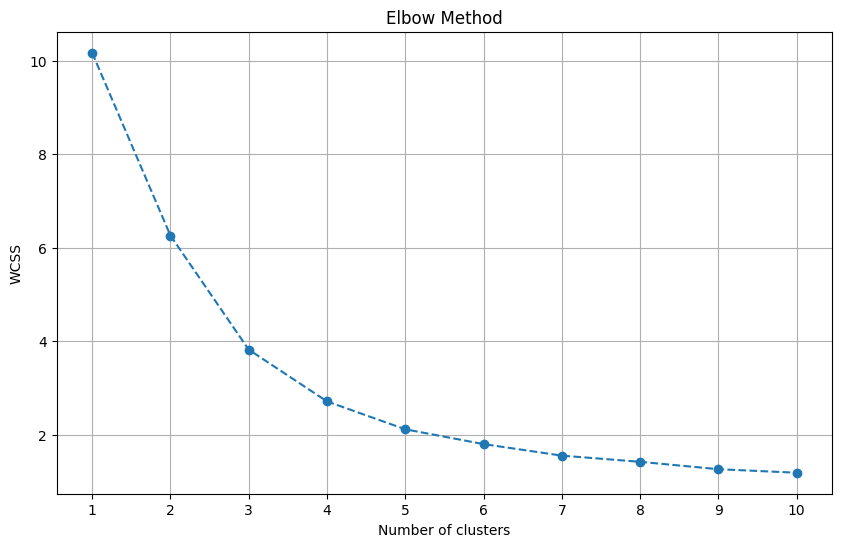

In [35]:
# Plotting the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(1, 11, 1))  # Ensure x-ticks are integers from 1 to 10
plt.grid(True)
plt.show()


### In this elbow graph, we can see that after n_clusters=3, the graph is getting stabilized. Therefore, the optimal number of clusters for k-means is 3

## Training the model with the optimal number of clusters found in the elbow point graph

In [36]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42) #set the new value of k, the init method, and keep the same random state

In [37]:
kmeans.fit_predict(new_balance_data) #now predict the new clusters for the data points

array([0, 2, 2, 0, 2, 0, 0, 2, 1, 1, 2, 0, 2, 0, 0, 0, 1, 2, 1, 0, 0, 0,
       0, 0, 1, 1, 2, 2, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 1, 0, 2,
       2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 2, 1,
       2, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1, 0, 2, 1, 0, 1, 1, 2, 0, 0,
       2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 2, 2, 0, 1, 1, 2, 0,
       2, 1, 1, 1, 1, 2, 1, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 1, 2, 2, 0, 2,
       2, 1, 0, 1, 0, 2, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2,
       1, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0,

In [38]:
kmeans_labels = kmeans.labels_

In [39]:
kmeans_labels

array([0, 2, 2, 0, 2, 0, 0, 2, 1, 1, 2, 0, 2, 0, 0, 0, 1, 2, 1, 0, 0, 0,
       0, 0, 1, 1, 2, 2, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 1, 0, 2,
       2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 2, 1,
       2, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1, 0, 2, 1, 0, 1, 1, 2, 0, 0,
       2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 2, 2, 0, 1, 1, 2, 0,
       2, 1, 1, 1, 1, 2, 1, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 1, 2, 2, 0, 2,
       2, 1, 0, 1, 0, 2, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2,
       1, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0,

## Plotting the clusters as a scatter plot


Text(0.5, 1.0, 'Kmeans Clustering')

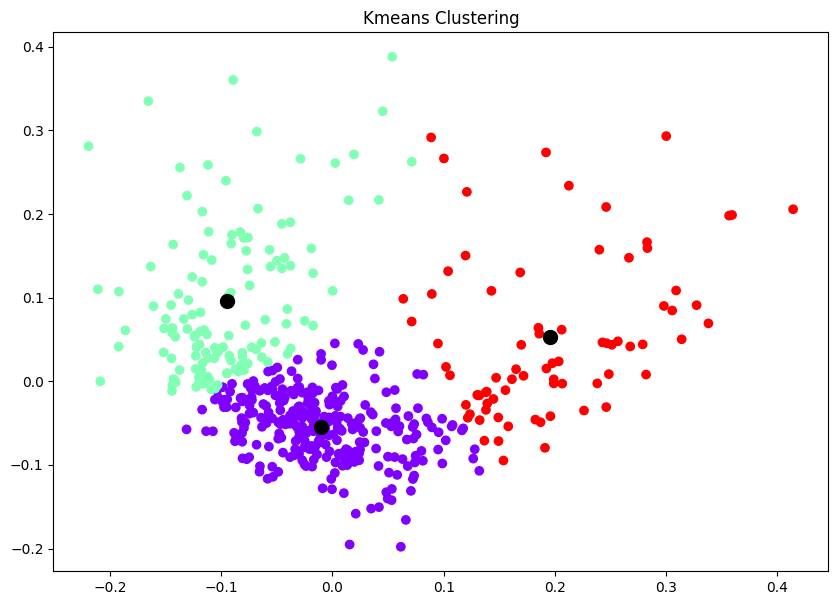

In [40]:
plt.figure(figsize=(10, 7))
plt.scatter( new_balance_data[:,0] , new_balance_data[:,1] ,  c=kmeans_labels, cmap='rainbow') #scatter plot all the points of the clusters
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1]  , s=100, c='black', label='centroid') #plot the centroids
plt.title('Kmeans Clustering')

## Checking the quality of the cluster of kmeans with the help of silhouette score


In [41]:
silhouette_score_kmeans = silhouette_score(new_balance_data , kmeans_labels ) #calculate the silhoutte score for the kmeans clusters
silhouette_score_kmeans

0.44336713197375954

## Implementing Agglomerative Hierarical Clustering Algorithm and finding the optimal number of clusters for agglomerative hierarical clustering algorithm

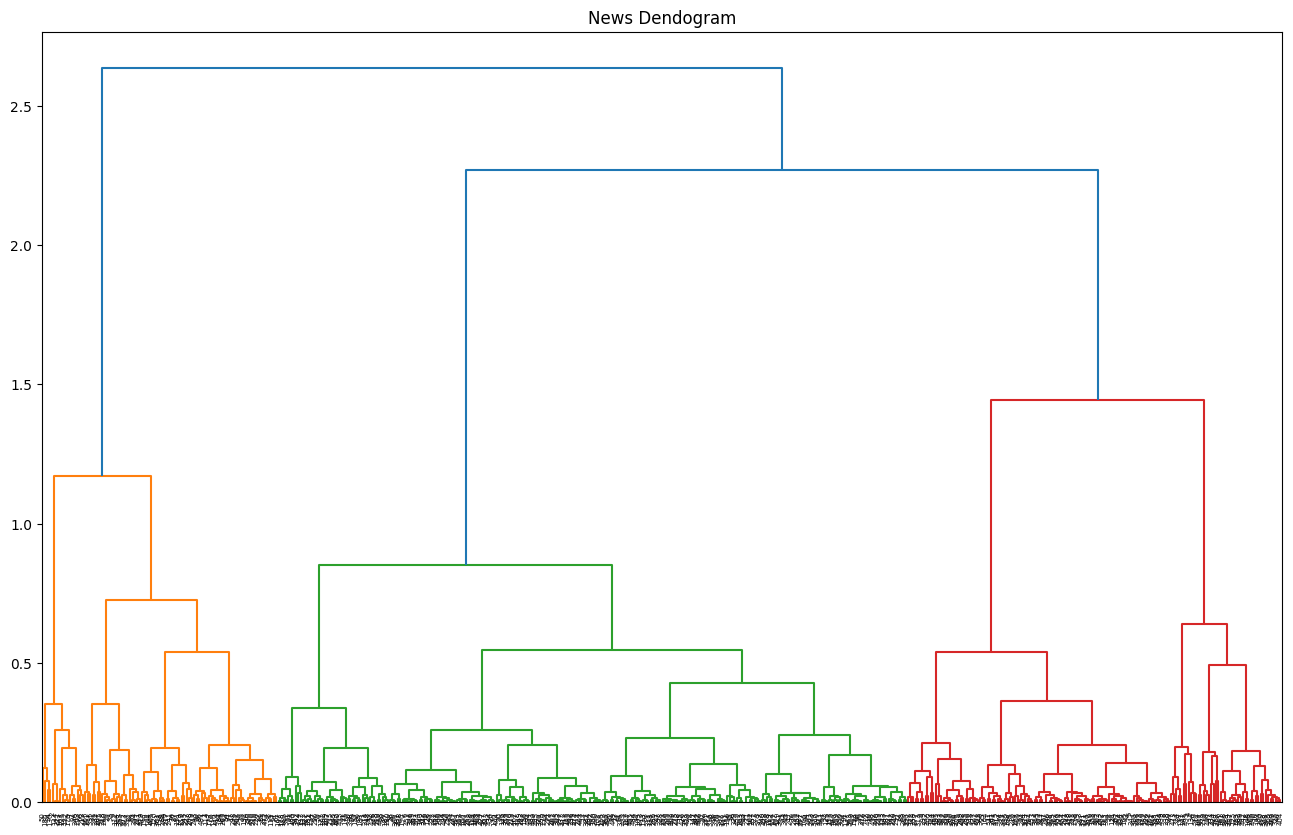

In [42]:
plt.figure(figsize=(16, 10))

plt.title('News Dendogram')

dend = shc.dendrogram(shc.linkage(new_balance_data, method='ward'))

### By cutting the dendrogram horizontally along the longest line, we get 3 clusters, indicating that the optimal number of clusters for agglomerative clustering is 3.

## Training the model with the optimal number of clusters found from the dendogram

In [43]:
cluster_hierarcial = AgglomerativeClustering(n_clusters=3, linkage='ward') #use Agglomorative clustering from scikit learn library, with 3 clusters and linkage ward

In [44]:
cluster_hierarcial.fit_predict(new_balance_data)

array([1, 1, 1, 2, 0, 0, 2, 1, 0, 0, 1, 0, 1, 2, 2, 2, 0, 1, 0, 2, 2, 2,
       2, 2, 0, 0, 0, 1, 0, 1, 2, 1, 2, 1, 1, 0, 2, 2, 1, 1, 2, 2, 0, 2,
       2, 2, 0, 2, 2, 0, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 0, 2, 1,
       1, 0, 0, 2, 2, 2, 2, 2, 0, 2, 1, 0, 2, 0, 2, 2, 1, 2, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       1, 1, 1, 0, 1, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 2, 0, 2, 2, 1, 0,
       1, 2, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 0, 2, 1, 2, 1, 0, 2, 1, 0, 2, 0, 0, 1, 2, 2,
       1, 2, 2, 1, 2, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 1, 1, 2, 0, 0, 1, 2,
       1, 0, 0, 0, 0, 1, 0, 2, 2, 1, 1, 2, 2, 1, 0, 1, 2, 0, 1, 1, 1, 1,
       1, 0, 2, 0, 2, 1, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1,
       0, 1, 0, 1, 1, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 1, 0, 0, 0,
       0, 1, 0, 2, 0, 2, 2, 1, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2,

In [45]:
hiearachy_labels = cluster_hierarcial.labels_ 

## Plotting the clusters as a scatter plot

Text(0.5, 1.0, 'Agglomerative Hierarical Clustering')

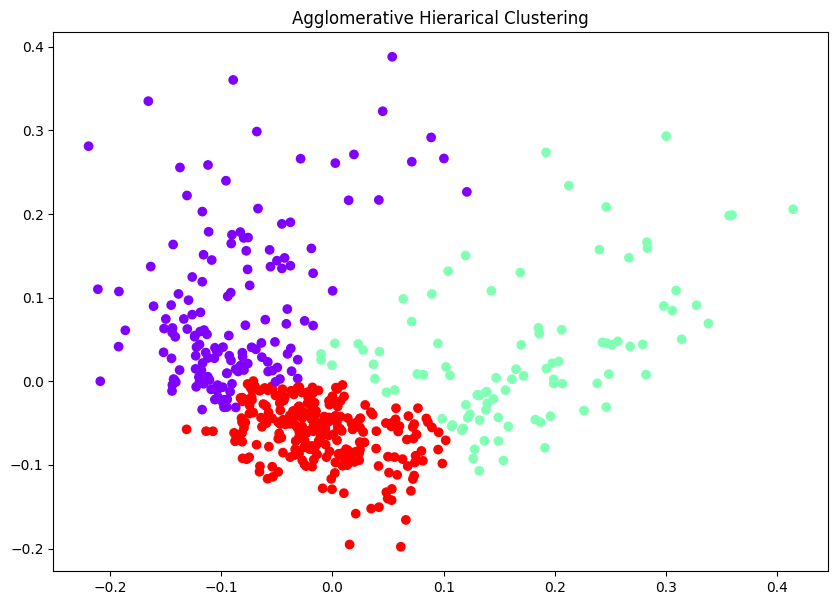

In [46]:
plt.figure(figsize=(10, 7))
plt.scatter(new_balance_data[:,0] , new_balance_data[:,1] , c=hiearachy_labels, cmap='rainbow') #plot the clusters
plt.title('Agglomerative Hierarical Clustering')

## Checking the quality of the cluster of agglomerative hierarical with the help of silhouette score

In [47]:
silhouette_score_hierarchy = silhouette_score(new_balance_data,hiearachy_labels ) #calculate silhoutte score
silhouette_score_hierarchy

0.4027081266260595

## Creating a table of the silhouette score of the two algorithm for better comparison

In [48]:
#create a dataframe that has two main columns: Algorithm and silhoutte score
silhoutte_score_df = pd.DataFrame({
    'Algorithm': ['k-means Clustering',  'Agglomerative Hierarical Clustering'],
    'Silhouette Score': [silhouette_score_kmeans, silhouette_score_hierarchy]
})

In [49]:
silhoutte_score_df

,Algorithm,Silhouette Score
0,k-means Clustering,0.443367
1,Agglomerative Hierarical Clustering,0.402708


Text(0.5, 1.0, 'Silhouette Score of each Algorithm')

<Figure size 1200x800 with 0 Axes>

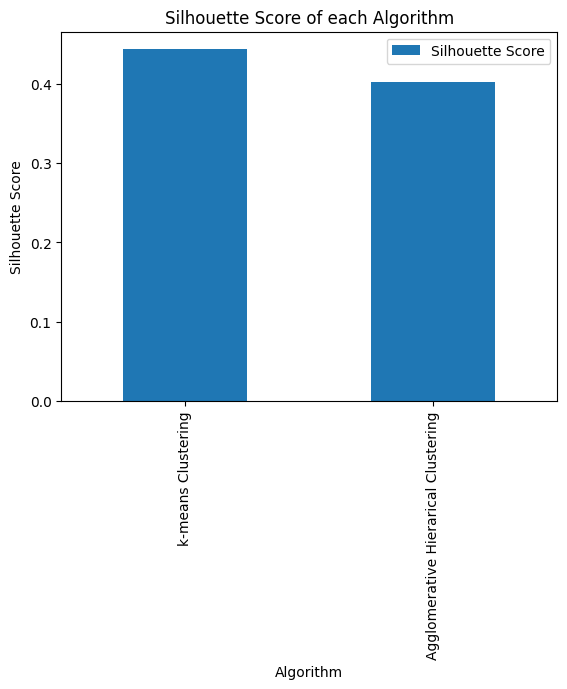

In [50]:
plt.figure(figsize=(12, 8))

silhoutte_score_df.plot(kind='bar', x='Algorithm')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score of each Algorithm')

## Conclusion

From the table and the graph, it is clear that the silhouette score of k-means Clustering is highest among the 2 indicating that it is the best clustering algorithm for our use case.

Therefore, for this project, THE OPTIMAL NUMBER OF CLUSTERS IS 3.